1. Data Exploration and Preprocessing
    - Number of samples in train and test dataset
    - Histogram of the length of samples 
    - Sample stats: number of words, chars, symbols, capital letters, etc. in each sample
    - Filter special symbols, clean sample's text
    - convert text to vectors using CountVectorizer or TfIdfVecorizer
2. Dimensionality reduction
    - Apply PCA with 3 or 2 components (to visualize), and explained variance 0.8, 0.9, 0.95 (for model training).
    - Try UMAP (to 3 or 2 components) to compare visualizations
3. Clustering
    - Perform clustering with K-Means, DBSCAN, and Hierarchical Clustering
    - For K-Means search for the optimal number of clustering with Elbow Method
    - Visualize clusters on 3 (or 2) dimensional samples
4. Write a report

In [1]:
from collections import Counter
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import umap

from yellowbrick.text import TSNEVisualizer
from yellowbrick.cluster import KElbowVisualizer

from src.helpers import read_comments_toxicity_csv, LABEL_COLUMNS
from src.textprep import preprocess_data_frame

In [2]:
RANDOM_STATE = 42

## 1. Data Exploration and Preprocessing

In [3]:
!head -5 ../data/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
"000103f0d9cfb60f","D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
"000113f07ec002fd","Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [4]:
!head -5 ../data/test.csv

,id,comment_text
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.
7,000247e83dcc1211,:Dear god this site is horrible.
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue?  You're just flailing, making up crap on the fly. 
 ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    


In [5]:
df_test_raw = pd.read_csv('../data/test.csv', index_col='id')[['comment_text']]

In [6]:
df_test_raw.head(5)

,comment_text
id,
0001ea8717f6de06,Thank you for understanding. I think very high...
000247e83dcc1211,:Dear god this site is horrible.
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [7]:
X_raw, y = read_comments_toxicity_csv('../data/train.csv')
X_raw.head(5)

,comment_text
id,
0000997932d777bf,Explanation\nWhy the edits made under my usern...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [8]:
y.head(5)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0000997932d777bf,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0


### Number of samples in train and test dataset

In [9]:
print(f"Number of samples in train dataset: {len(X_raw)}")
print(f"Number of samples in test dataset: {len(df_test_raw)}")

Number of samples in train dataset: 159571
Number of samples in test dataset: 63978


### Histogram of the length of samples 

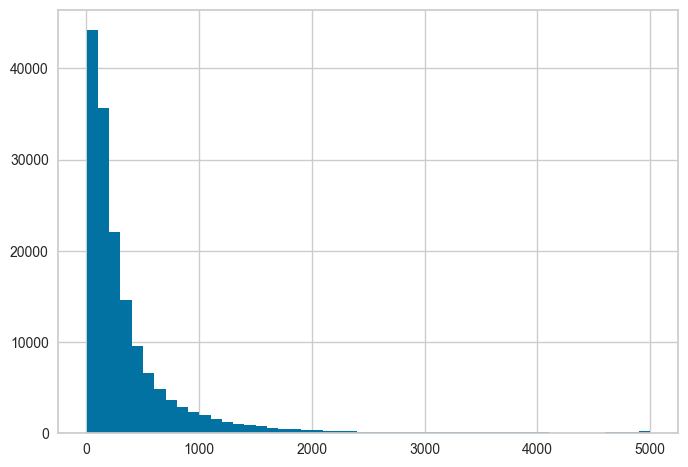

In [10]:
X_raw['comment_text'].map(len).hist(bins=50);

### Sample stats: number of words, chars, symbols, capital letters, etc. in each sample

In [11]:
raw_comments = [comment for _, comment in X_raw['comment_text'].items()]

In [12]:
def compute_stats_for_comment(comment: str) -> Counter:
    counter = Counter()
    counter['words'] += len(re.findall('\w+', comment.lower()))
    counter['chars'] += sum(c.isalnum() for c in comment)
    counter['symbols (special character)'] += sum(c in r'!"#$%&\'()*+,-./:;<=>?@{|}~]^_[' for c in comment)
    counter['capital letters'] += sum(c.isupper() for c in comment)
    return counter

In [13]:
all_stats = sum((compute_stats_for_comment(comment) for comment in raw_comments), start=Counter())

In [14]:
pd.Series({f'Number of {statistic} per sample': count / len(raw_comments) for statistic, count in all_stats.items()})

Number of words per sample                           69.176962
Number of chars per sample                          308.538851
Number of symbols (special character) per sample     15.881821
Number of capital letters per sample                 17.159628
dtype: float64

### Filter special symbols, clean sample's text

Here we reuse preprocessing from the homework #4

In [15]:
X = preprocess_data_frame(X_raw)

### convert text to vectors using CountVectorizer or TfIdfVecorizer

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.95)

In [17]:
X_vectorized_array = tfidf_vectorizer.fit_transform(X).toarray()

In [18]:
X_vectorized = pd.DataFrame(X_vectorized_array, index=X.index)

In [19]:
X_vectorized.shape

(159571, 1000)

## 2. Dimensionality reduction

Here we introduce `X_vec_subset` and `y_vec_subset` that represent vectorized random subset of train data so that further calculations are computationally feasible

In [20]:
X_vec_subset, _, y_vec_subset, _ = train_test_split(X_vectorized, y, train_size=10_000, random_state=RANDOM_STATE)

In [21]:
X_vec_subset.shape

(10000, 1000)

In [22]:
y_vec_subset.shape

(10000, 6)

## Apply PCA with 3 or 2 components (to visualize), and explained variance 0.8, 0.9, 0.95 (for model training).

In [23]:
def make_scaled_pca(n_components: int | float) -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=n_components, random_state=RANDOM_STATE)),
    ])

In [24]:
pca_2d = make_scaled_pca(n_components=2)

In [25]:
X_pca_2d = pca_2d.fit_transform(X_vec_subset)

In [26]:
X_pca_2d

array([[-0.94535622, -2.74822282],
       [-1.31663235, -2.30717328],
       [ 0.34044068,  0.13546652],
       ...,
       [-1.03302989,  0.42498571],
       [-0.72706389, -1.02285234],
       [-1.35867973, -0.59924724]])

In [27]:
pca_2d['reducer'].explained_variance_ratio_

array([0.00657111, 0.00496494])

As we can see here, 2-dimensional PCA preserves only about 1% of variance.

In [28]:
def visualize_2d_reduced_features(features_2, x_lim=None, y_lim=None):
    alpha_0 = 0.1
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    for label_index, label_column in enumerate(LABEL_COLUMNS):
        axes = ax[label_index // 3][label_index % 3]
        axes.title.set_text(label_column)
        if x_lim is not None:
            axes.set_xlim(x_lim)
        if y_lim is not None:
            axes.set_ylim(y_lim)
        axes.scatter(
            features_2[:, 0], features_2[:, 1],
            c=y_vec_subset[label_column],
            s=10,
            alpha=y_vec_subset[label_column] * (1 - alpha_0) + alpha_0,
            cmap=plt.get_cmap('viridis'),
        )

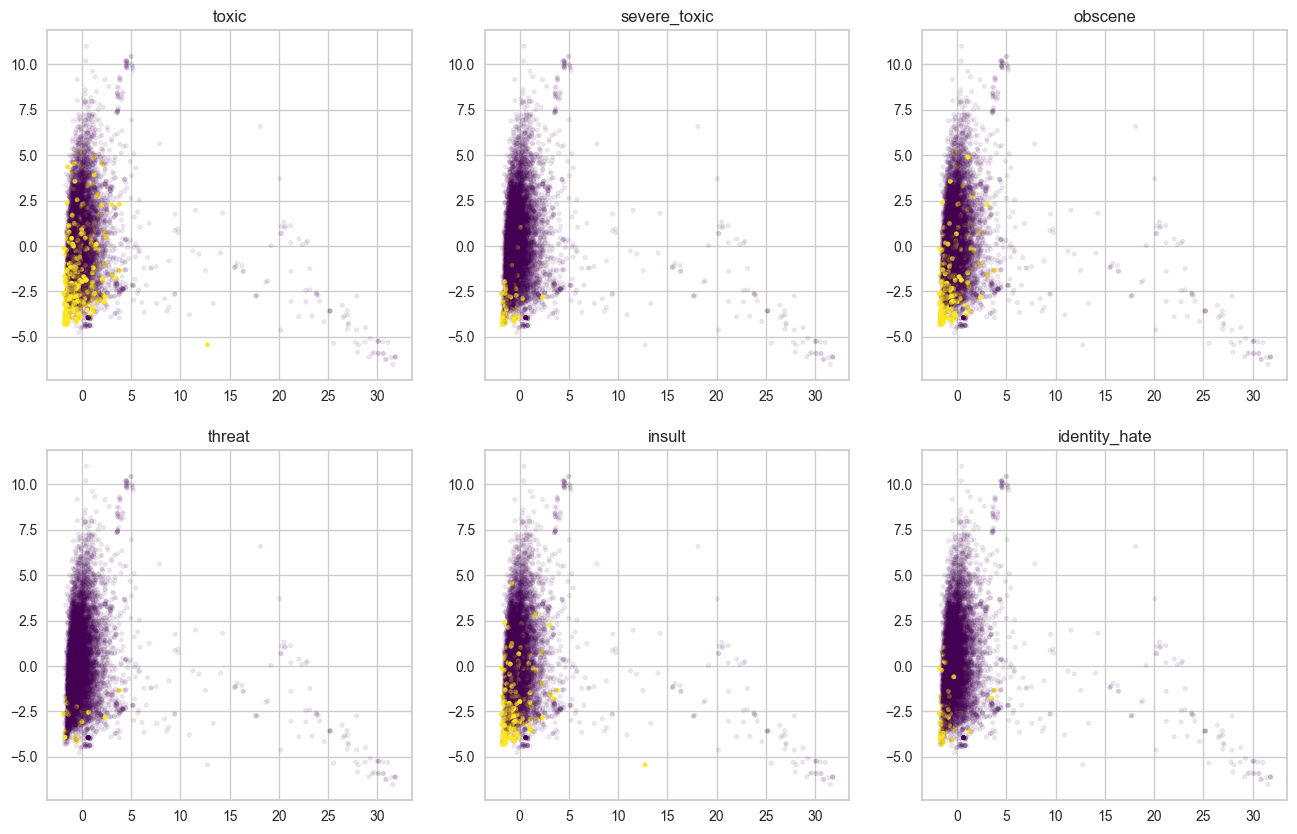

In [29]:
visualize_2d_reduced_features(X_pca_2d)

In [30]:
trained_pca_models = [
    make_scaled_pca(n_components=target_explained_variance_ratio).fit(X_vec_subset)
    for target_explained_variance_ratio in [0.8, 0.9, 0.95]
]

In [31]:
pd.DataFrame([(pca['reducer'].n_components, pca['reducer'].n_components_) for pca in trained_pca_models], columns=['target explained variance ratio', 'num of principal components'])

,target explained variance ratio,num of principal components
0,0.80,679
1,0.90,819
2,0.95,900


### Try UMAP (to 3 or 2 components) to compare visualizations

In [32]:
def make_umap(n_components=2):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', umap.UMAP(n_components=n_components)),
    ])

In [33]:
umap_2d = make_umap()

In [34]:
X_umap_2d = umap_2d.fit_transform(X_vec_subset)

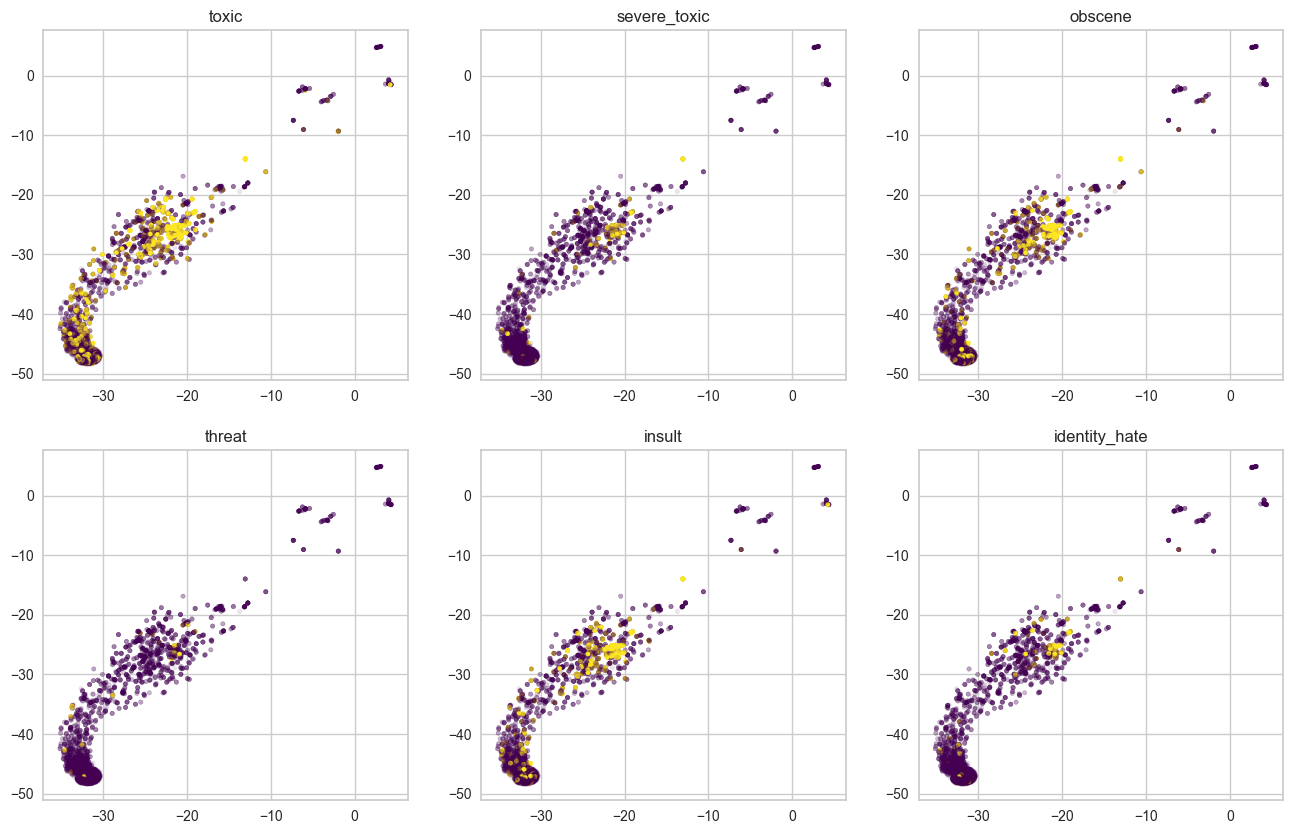

In [35]:
visualize_2d_reduced_features(X_umap_2d)

## Clustering

### Perform clustering with K-Means, DBSCAN, and Hierarchical Clustering

For clustering, we use UMAP for dimensionality reduction. PCA turned out not to be enough information in order to use elbow method.

In [36]:
X_vec_subset_reduced = make_umap(50).fit_transform(X_vec_subset)

In [37]:
X_vec_subset_reduced.shape

(10000, 50)

#### DBSCAN

In [38]:
def make_scaled_dbscan(eps: float):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', DBSCAN(eps=eps)),
    ])

In [39]:
dbscan = make_scaled_dbscan(eps=3)
dbscan_clusters = dbscan.fit_predict(X_vec_subset_reduced)

#### Hierarchical Clustering

In [40]:
# taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [41]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=4, compute_distances=True)
hierarchical_clusters = agglomerative_clustering.fit_predict(X_vec_subset_reduced)

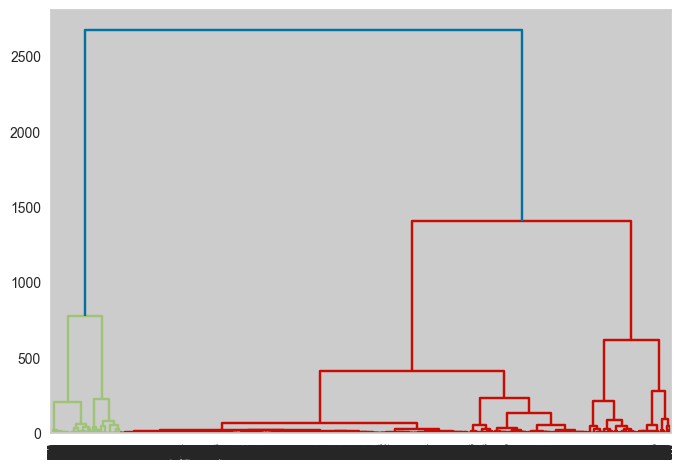

In [42]:
plot_dendrogram(agglomerative_clustering)

### For K-Means search for the optimal number of clustering with Elbow Method

In [43]:
def make_scaled_kmeans(n_clusters: int):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', KMeans(n_clusters=n_clusters, n_init=10, random_state=RANDOM_STATE)),
    ])

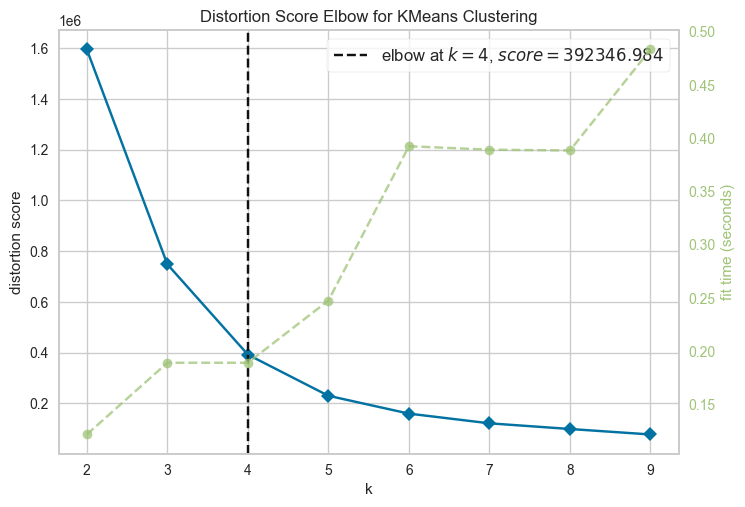

In [44]:
elbow_visualizer = KElbowVisualizer(KMeans(n_init=10, random_state=RANDOM_STATE), k=range(2, 10))

elbow_visualizer.fit(X_vec_subset_reduced)
elbow_visualizer.show();

Let's retrain kmeans with number of clusters proposed by the elbow method above.

In [45]:
kmeans_clusters = make_scaled_kmeans(n_clusters=4).fit_predict(X_vec_subset_reduced)

### Visualize clusters on 3 (or 2) dimensional samples

In [46]:
def visualize_clusters_tsne(clusters, ax, title: str):
    tsne_visualizer = TSNEVisualizer(ax=ax, random_state=RANDOM_STATE)
    tsne_visualizer.fit(X_vec_subset_reduced, clusters)
    if title is not None:
        ax.set_title(title)

/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(
/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(
/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/yellowbrick/text/

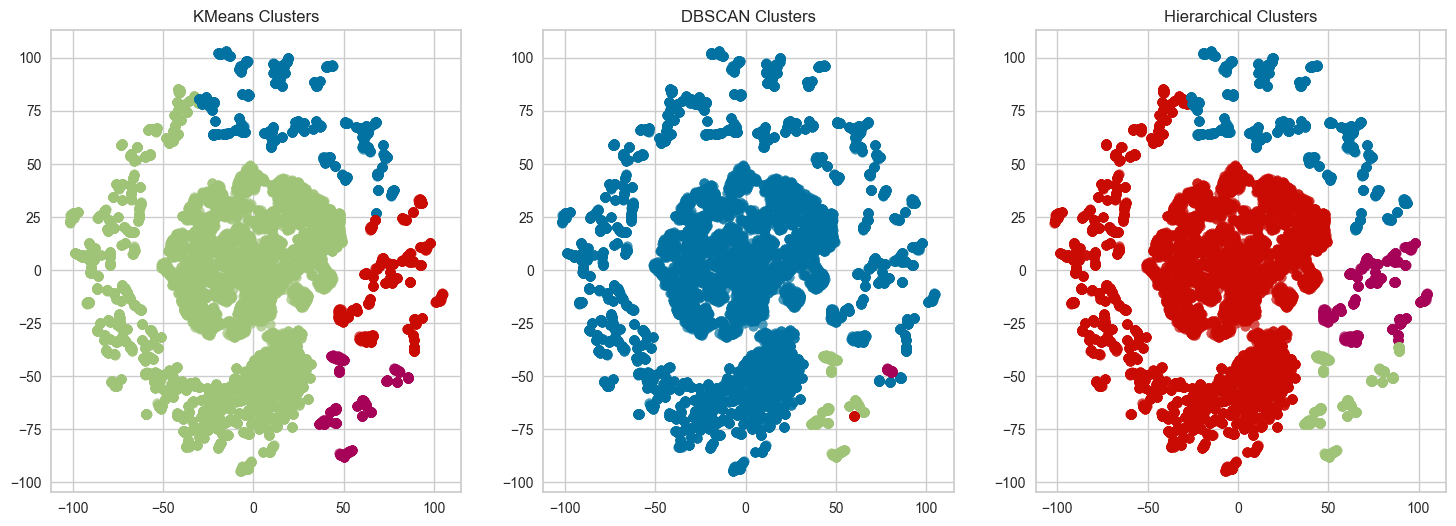

In [47]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
visualize_clusters_tsne(kmeans_clusters, ax1, 'KMeans Clusters')
visualize_clusters_tsne(dbscan_clusters, ax2, 'DBSCAN Clusters')
visualize_clusters_tsne(hierarchical_clusters, ax3, 'Hierarchical Clusters')

## Conclusion

With the given `toxicity` dataset we were able to do the following:
   - looked at the dataset, computed basic statistics, estimated its size
   - preprocessed text by filter special characters, tokenization, removing stop words
   - vectorized preprocessed text with TFIDF
   - applied PCA and UMAP in order to do dimensionality reduction and visualization
   - performed clustering with KMeans, DBSCAN and Hierarchical clustering algorithms

It should be noted, that calculated clusters still show locality when visualized in 2d.

Another notable result is that after plotting target labels on 2d scatter plot obtained by 2d PCA,
some target labels ('severe_toxic', 'threat' and 'identity_hate') look like linearly separable
despite the fact that 2d PCA transform preserved only about %1 of variance.